<a href="https://colab.research.google.com/github/Alexjmsherman/nlp_practicum_cohort3_student/blob/master/lessons/lesson_8_text_similarity/text_similarity_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Similarity

##### Author: Alex Sherman | alsherman@deloitte.com

### Agenda:

- Levenshtein distance
- Jaccard distance
- Euclidean distance
- Cosine similarity
- Similarity with [sklearn, gensim, spacy]
- Similarity with word embeddings (Word2vec similarity, Word movers distance)
- Similarity of Probability Distributions (Cross entropy, KL Divergence, Hellinger distance)
- Nearest-neighbors search
- Clustering

"we often want to determine **similarity between pairs of documents**, or the **similarity between a specific document** and a set of other documents (such as a user query vs. indexed documents).


### Use cases:
Broad:
- information retrieval
- document clustering
- word-sense disambiguation
- automatic essay scoring
- short answer grading
- machine translation
- Recommendation Engines
- Search Engines (Query - Result matching)

Specific:
- Grant similarity
- Complaint similarity
- Duplicate questions
- Question Answering (e.g. give the same style of question to a customer support agent)

In [0]:
from configparser import ConfigParser, ExtendedInterpolation
from collections import defaultdict
from itertools import combinations, product
import warnings
warnings.filterwarnings('ignore')

import gensim
from gensim import corpora, models, similarities
from gensim.corpora import Dictionary
from gensim.matutils import kullback_leibler, hellinger
from gensim.models import ldamodel
from gensim.similarities import MatrixSimilarity, SparseMatrixSimilarity, Similarity
from gensim.summarization.bm25 import get_bm25_weights
from gensim.utils import simple_preprocess
from IPython.core.display import display, HTML
from IPython.display import Image
from IPython.lib.display import YouTubeVideo
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from spacy.matcher import Matcher
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.neighbors import NearestNeighbors
import spacy

# increase display of columns in pandas
pd.set_option('display.max_colwidth', 200)

In [0]:
CLEANED_TEXT_PATH = r'https://raw.githubusercontent.com/Alexjmsherman/nlp_practicum_cohort3_student/master/raw_data/cleaned_text/cleaned_text.txt?token=ABXRUPXERSXJFQO35372DAK5H7AP6'
SIMILARITY_INDEX = 'pubmed.index'

In [0]:
# configuration for data, acronyms, and gensim paths
config = ConfigParser(interpolation=ExtendedInterpolation())
config.read('../../config.ini')

GENSIM_DICTIONARY_PATH = config['NLP']['GENSIM_DICTIONARY_PATH']
GENSIM_CORPUS_PATH = config['NLP']['GENSIM_CORPUS_PATH']
CLEANED_TEXT_PATH = config['NLP']['CLEANED_TEXT_PATH']
SIMILARITY_INDEX = config['NLP']['SIMILARITY_INDEX']
SAVED_EMBEDDINGS_PATH = config['EMBEDDINGS']['SAVED_EMBEDDINGS_PATH']
REPORTER_ZIP_PATH = config['EMBEDDINGS']['REPORTER_ZIP_PATH']

### Review Cleaned Text

In [56]:
cleaned_text_df = pd.read_table(CLEANED_TEXT_PATH, names=['text'], header=None)
cleaned_text = cleaned_text_df.text.values
cleaned_text_df.head()

,text
0,immune_complexes in rheumatic disease
1,gluten and lymphocytes in coeliac_disease
2,this activity correlated best with the severity and duration of the disease rather than with gamma_globulin or total protein concentrations
3,evidence exists that they control some of the peripheral manifestations of the disease including nervousness palpitations tachycardia increased cardiac output and tremor but they do not appear to ...
4,the finding of additional substitute cf antigens for the hrvl agent may have implications in the against human disease


### Text Similarity Approaches

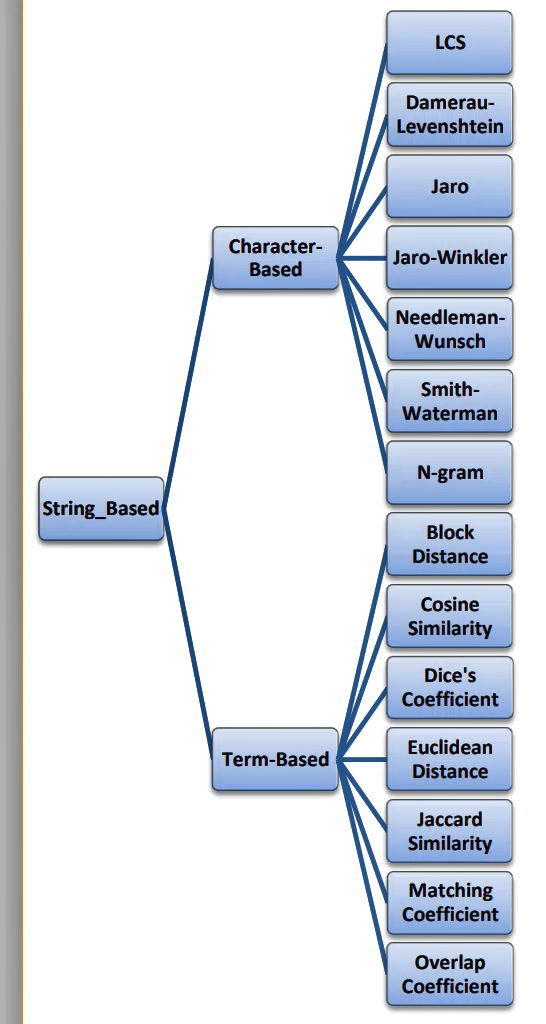

In [12]:
# text similarity approaches
# SOURCE: https://pdfs.semanticscholar.org/5b5c/a878c534aee3882a038ef9e82f46e102131b.pdf
Image("https://s3.amazonaws.com/nlp.practicum/text_similarity_approaches.png", width=350)

## Character Based Text Similarity

"As an example, this technology is used by information retrieval systems, search engines, automatic indexing systems, text summarizers, categorization systems, plagiarism checkers, speech recognition, rating systems, DNA analysis, and profiling algorithms (IR/AI programs to automatically link data between people and what they do)."

##### The Levenshtein Distance

"This method was invented in 1965 by the Russian Mathematician Vladimir Levenshtein (1935-2017). The distance value describes the minimal number of deletions, insertions, or substitutions that are required to transform one string (the source) into another (the target). Unlike the Hamming distance, the Levenshtein distance works on strings with an unequal length."

SOURCE: [Levenshtein Distance and Text Similarity in Python](http://stackabuse.com/levenshtein-distance-and-text-similarity-in-python/)

In [13]:
seq1 = 'medicine'
seq2 = 'medical'

# create a matrix
size_x = len(seq1) + 1
size_y = len(seq2) + 1
matrix = np.zeros ((size_x, size_y))
matrix

array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.]])

In [14]:
# set col numbers (0, n-1)
for x in range(size_x):
    matrix [x, 0] = x

# set row numbers (0, n-1)
for y in range(size_y):
    matrix [0, y] = y

matrix

array([[0., 1., 2., 3., 4., 5., 6., 7.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [2., 0., 0., 0., 0., 0., 0., 0.],
       [3., 0., 0., 0., 0., 0., 0., 0.],
       [4., 0., 0., 0., 0., 0., 0., 0.],
       [5., 0., 0., 0., 0., 0., 0., 0.],
       [6., 0., 0., 0., 0., 0., 0., 0.],
       [7., 0., 0., 0., 0., 0., 0., 0.],
       [8., 0., 0., 0., 0., 0., 0., 0.]])

In [15]:
import numpy as np

def levenshtein(seq1, seq2):
    # create a matrix
    size_x = len(seq1) + 1
    size_y = len(seq2) + 1
    matrix = np.zeros ((size_x, size_y))
    
    # set col numbers (0, n-1)
    for x in range(size_x):
        matrix [x, 0] = x
    
    # set row numbers (0, n-1)
    for y in range(size_y):
        matrix [0, y] = y

    # calculate distance
    for x in range(1, size_x):
        for y in range(1, size_y):
            # if characters match do not increase distance
            if seq1[x-1] == seq2[y-1]:
                matrix [x,y] = matrix[x-1, y-1]
            # if characters don't match increase min distance by 1
            else:
                matrix [x,y] = min(
                    matrix[x-1,y] + 1,
                    matrix[x-1,y-1] + 1,
                    matrix[x,y-1] + 1
                )

    # print the distance calulation matrix
    # list(seq1) converts string into a list of the characters
    print(pd.DataFrame(matrix[1:,1:], index=list(seq1), columns=list(seq2)))
    
    return (matrix[size_x - 1, size_y - 1])

levenshtein('medicine','medical')

     m    e    d    i    c    a    l
m  0.0  1.0  2.0  3.0  4.0  5.0  6.0
e  1.0  0.0  1.0  2.0  3.0  4.0  5.0
d  2.0  1.0  0.0  1.0  2.0  3.0  4.0
i  3.0  2.0  1.0  0.0  1.0  2.0  3.0
c  4.0  3.0  2.0  1.0  0.0  1.0  2.0
i  5.0  4.0  3.0  2.0  1.0  1.0  2.0
n  6.0  5.0  4.0  3.0  2.0  2.0  2.0
e  7.0  6.0  5.0  4.0  3.0  3.0  3.0


3.0

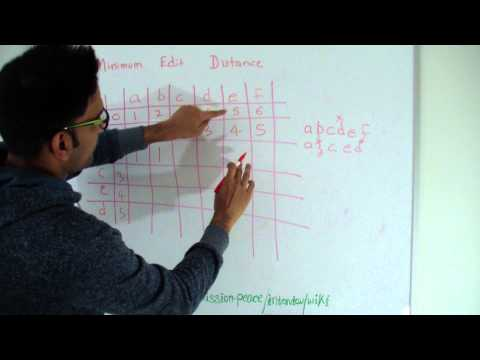

In [16]:
from IPython.lib.display import YouTubeVideo
YouTubeVideo('We3YDTzNXEk')

## Term Based Text Similarity

In [22]:
# create a document-term matrix for the first 10 documents
vect = CountVectorizer(max_features=10)
transform_vect = vect.fit_transform(cleaned_text_df['text'][0:10])

# rename the indices as doc_#
index = ['doc_{}'.format(i) for i in range(10)]

# create a dataframe
dist_df = pd.DataFrame(
      transform_vect.todense()
    , columns=vect.get_feature_names()
    , index=index
)

# view two docs
dist_df.loc[['doc_1','doc_7'],:]

,and,cases,disease,in,of,per,survived,the,they,with
doc_1,1,0,0,1,0,0,0,0,0,0
doc_7,0,0,1,0,3,0,0,0,0,2


### Jaccard Index

"The Jaccard Index is a statistic to compare and measure how similar two different sets to each other. It is a ratio of intersection of two sets over union of them.

If you have representative finite number of elements for a particular observation and you want to compare this observation with another observation, you could count the number of items that are common to both of these two sets. It is a natural fit for comparing posts if you know the representative tags for the posts to measure how similar two articles are in terms of tags."

SOURCE: http://bugra.github.io/work/notes/2017-02-07/similarity-via-jaccard-index/

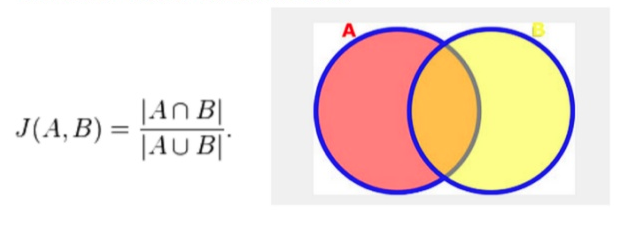

In [20]:
# Similarity via the Jaccard Index
Image("https://s3.amazonaws.com/nlp.practicum/jaccard_index.png", width=450)

In [0]:
# calculate the distance among different vectors
#
# NOTE: if both counts are zero, then the term in not counted in the denominator
#       as the term is outside of the union of both term sets

from sklearn.metrics.pairwise import pairwise_distances

# calculate jaccard distance on all documents
jaccard = pairwise_distances(dist_df.values, metric='jaccard')

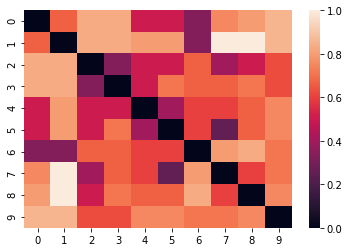

In [90]:
sns.heatmap(pairwise_distances(dist_df.values, Y=None, metric='jaccard'));

In [91]:
for doc_ind in range(0,5):
    print('jaccard distance {}'.format(jaccard[0][doc_ind])) # focus on the first doc (index 0)
    print(dist_df.iloc[[0, doc_ind], :], '\n\n')  # print the first doc and the comparison document

jaccard distance 0.0
       and  cases  disease  in  of  per  survived  the  they  with
doc_0    0      0        1   1   0    0         0    0     0     0
doc_0    0      0        1   1   0    0         0    0     0     0 


jaccard distance 0.6666666666666666
       and  cases  disease  in  of  per  survived  the  they  with
doc_0    0      0        1   1   0    0         0    0     0     0
doc_1    1      0        0   1   0    0         0    0     0     0 


jaccard distance 0.8333333333333334
       and  cases  disease  in  of  per  survived  the  they  with
doc_0    0      0        1   1   0    0         0    0     0     0
doc_2    1      0        1   0   1    0         0    2     0     2 


jaccard distance 0.8333333333333334
       and  cases  disease  in  of  per  survived  the  they  with
doc_0    0      0        1   1   0    0         0    0     0     0
doc_3    1      0        1   0   2    0         0    3     2     0 


jaccard distance 0.5
       and  cases  disease  in  of

### Euclidean Distance

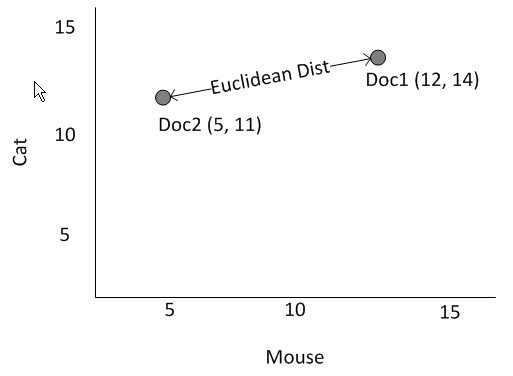

In [28]:
# the geometric equation of the dot product
Image("https://s3.amazonaws.com/nlp.practicum/euclidean_distance.jpg", width=300)

In [0]:
def euclidean_distance(x, y):   
    return np.sqrt(np.sum((x - y) ** 2))

In [30]:
# 3-4-5 triangle
p1 = np.array([0,0])
p2 = np.array([3,4])
euclidean_distance(x=p1, y=p2)

5.0

In [31]:
# 0-3, 0-4
p1 - p2

array([-3, -4])

In [32]:
# -3^2, -4^2
(p1 - p2) ** 2

array([ 9, 16])

In [33]:
# 9 + 16
np.sum((p1 - p2) ** 2)

25

In [34]:
# sqrt(25)
np.sqrt(np.sum((p1 - p2) ** 2))

5.0

In [35]:
# example from above diagram
p1 = np.array([5,11])
p2 = np.array([12,14])
euclidean_distance(x=p1, y=p2)

7.615773105863909

In [36]:
# euclidean distance scales beyond 2-D
p1 = np.array([0,0,0])
p2 = np.array([3,3,3])
euclidean_distance(x=p1, y=p2)

5.196152422706632

In [37]:
# the distance between a vect and itself is 0
euclid_df = dist_df 
euclidean_distance(euclid_df.iloc[0], euclid_df.iloc[0])

0.0

In [38]:
# calculate the distance among different vectors
for doc_ind in range(1,8):
    print(euclidean_distance(euclid_df.iloc[0], euclid_df.iloc[doc_ind]))

1.4142135623730951
3.3166247903554
4.358898943540674
3.1622776601683795
1.4142135623730951
1.0
3.7416573867739413


[0.         1.41421356 3.31662479 4.35889894 3.16227766 1.41421356
 1.         3.74165739 2.         4.79583152]


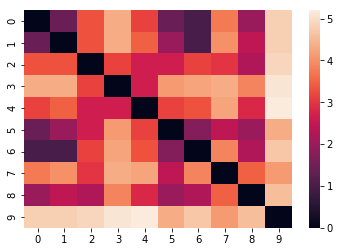

In [39]:
print(pairwise_distances(euclid_df, Y=None, metric='euclidean')[0])
sns.heatmap(pairwise_distances(euclid_df, Y=None, metric='euclidean'));

### Cosine Similarity

##### Dot Product

"The dot product for two vectors of a and b where a_n and b_n are the components of the vector (features of the document or TF-IDF values for each word of the document in our example)"

Imagine two documents:
- a = 'medicine medicine medicine'
- b = 'biomedical biomedical biomedical biomedical'

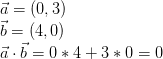

In [41]:
# example dot product calculation
Image("https://s3.amazonaws.com/nlp.practicum/dot_product_calculation.png", width=200)

The CountVectorizer output of the two documents show the word count, where the vectors do not overlap for any words. Thus the dot product is zero.

In [42]:
# dot product equation
Image("https://s3.amazonaws.com/nlp.practicum/dot_product.png", width=500)

### The Norm

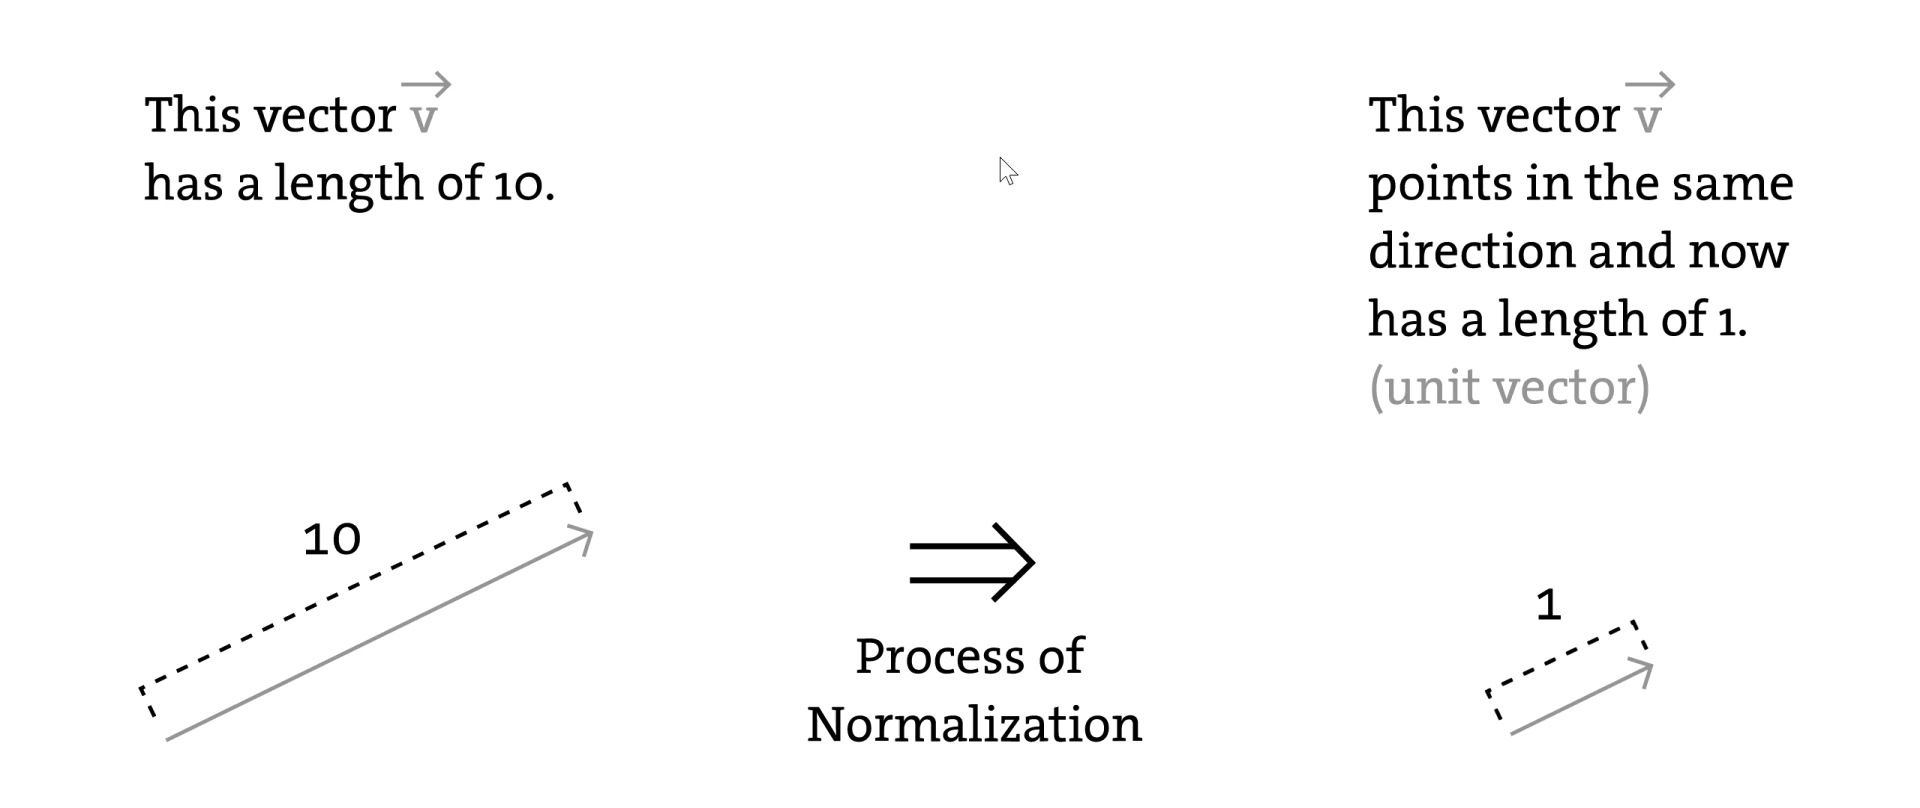

In [44]:
# the geometric equation of the dot product
Image("https://s3.amazonaws.com/nlp.practicum/normalization.png", width=800)

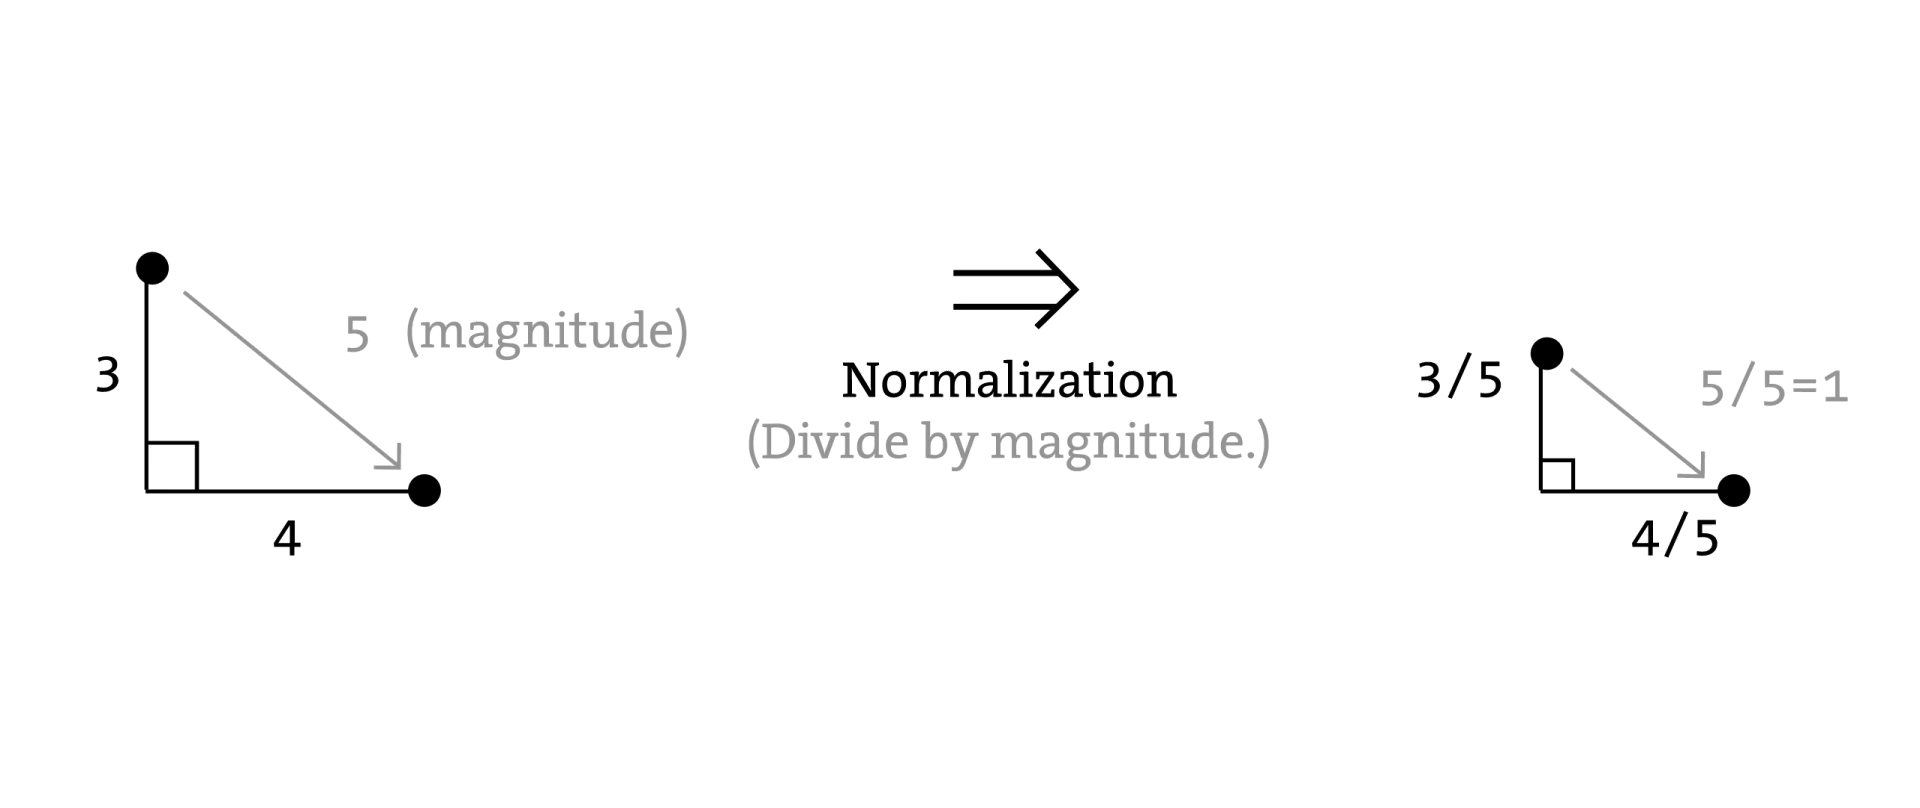

In [45]:
# the geometric equation of the dot product
Image("https://s3.amazonaws.com/nlp.practicum/normalization_example.png", width=800)

In [46]:
norm_url = 'https://rorasa.wordpress.com/2012/05/13/l0-norm-l1-norm-l2-norm-l-infinity-norm/'
iframe = '<iframe src={} width=1100 height=300></iframe>'.format(norm_url)
HTML(iframe)

##### cosine similarity
The cosine similarity between two vectors (or two documents on the Vector Space) is a measure that calculates the cosine of the angle between them. This metric is a measurement of orientation and not magnitude, it can be seen as a comparison between documents on a normalized space because we’re not only taking into the consideration the magnitude of each word count (tf-idf) of each document, but also the angle between the documents. What we have to do to build the cosine similarity equation is to solve the equation of the dot product for cosine:


That is the cosine similarity formula. Cosine Similarity will generate a metric that says how related are two documents by looking at the angle instead of the magnitude.

In [47]:
# the geometric equation of the dot product
Image("https://s3.amazonaws.com/nlp.practicum/geometric_dot_product.png", width=200)

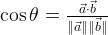

In [48]:
# cosine similarity equation
Image("https://s3.amazonaws.com/nlp.practicum/cosine_similarity.png", width=200)

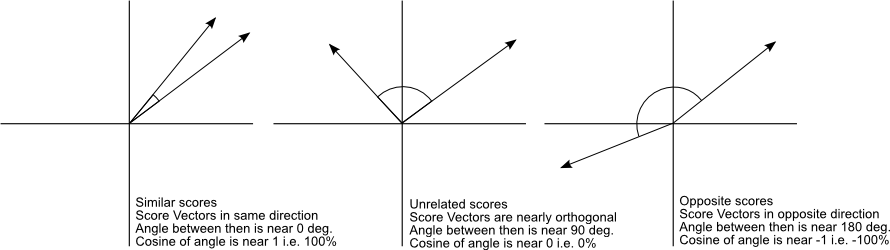

In [49]:
# cosine similarity angles
# 1 = perfect match
# 0 = dissimilar documents
Image("https://s3.amazonaws.com/nlp.practicum/cosine_similarity_angles.png", width=1200)

In [51]:
cosine_url = 'http://blog.christianperone.com/2013/09/machine-learning-cosine-similarity-for-vector-space-models-part-iii/'
iframe = '<iframe src={} width=950 height=300></iframe>'.format(cosine_url)
HTML(iframe)

# Similarity with sklearn

### tfidf -> lsi -> cosine similarity (sklearn)

In [57]:
# view the tfidf scores
from sklearn.feature_extraction.text import TfidfVectorizer

# create tfidf matrix
df = pd.DataFrame(cleaned_text[0:5], columns=['text'])
vect = TfidfVectorizer(max_features=15)
transform_vect = vect.fit_transform(df['text'])
pd.DataFrame(transform_vect.toarray(), columns=vect.get_feature_names())

,and,disease,in,manifestations,may,nervousness,of,or,output,palpitations,peripheral,process,the,they,with
0,0.000000,0.643744,0.765241,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.707107,0.000000,0.707107,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.236653,0.199080,0.000000,0.000000,0.000000,0.000000,0.236653,0.353366,0.000000,0.000000,0.000000,0.000000,0.473307,0.000000,0.706732
3,0.164391,0.138291,0.000000,0.245466,0.000000,0.245466,0.328782,0.000000,0.245466,0.245466,0.245466,0.245466,0.493173,0.490931,0.000000
4,0.000000,0.225334,0.267862,0.000000,0.399966,0.000000,0.267862,0.000000,0.000000,0.000000,0.000000,0.000000,0.803586,0.000000,0.000000


In [58]:
# reduce the dimensions using SVD
from sklearn.decomposition import TruncatedSVD

# reduce dimensions of tfidf matrix
svd = TruncatedSVD(n_components=2)
svd_tranform = svd.fit_transform(transform_vect)
print(svd_tranform)

[[ 0.60221748  0.64910952]
 [ 0.55291769  0.66439966]
 [ 0.67303251 -0.37007132]
 [ 0.6541612  -0.47012367]
 [ 0.81208021 -0.24832119]]


##### Build a recommendation engine with cosine similarity

In [0]:
from sklearn.neighbors import NearestNeighbors

In [60]:
# EXAMPLE

# sample data
X = [[1,1], [1,2], [1,3], [1,4], [1,5]]

# calculate cosine distance
nn = NearestNeighbors(metric='cosine')
nn.fit(X)

# build a graph of the nearest neighbors using cosine distance
nn_graph = nn.kneighbors_graph(n_neighbors=4, mode='distance').toarray()
pd.DataFrame(nn_graph)

,0,1,2,3,4
0,0.000000,0.051317,0.105573,0.142507,0.167950
1,0.051317,0.000000,0.010051,0.023813,0.035236
2,0.105573,0.010051,0.000000,0.002946,0.007722
3,0.142507,0.023813,0.002946,0.000000,0.001132
4,0.167950,0.035236,0.007722,0.001132,0.000000


In [61]:
# calculate cosine distance
cosine_neighbors = NearestNeighbors(metric='cosine')
cosine_neighbors.fit(svd_tranform)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [62]:
# build a graph of the nearest neighbors using cosine distance
ind = ['doc{}'.format(i) for i in range(1,6)]
graph = cosine_neighbors.kneighbors_graph(n_neighbors=2, mode='distance').toarray()
pd.DataFrame(graph, columns=ind, index=ind)

,doc1,doc2,doc3,doc4,doc5
doc1,0.000000,0.001451,0.000000,0.000000,0.563966
doc2,0.001451,0.000000,0.000000,0.000000,0.613053
doc3,0.000000,0.000000,0.000000,0.007241,0.021139
doc4,0.000000,0.000000,0.007241,0.000000,0.052794
doc5,0.000000,0.000000,0.021139,0.052794,0.000000


The similarity in vector space models is determined by using associative coefficients based on the inner product of the document vector and query vector, where word overlap indicates similarity. The inner product is usually normalized. The most popular similarity measure is the cosine coefficient, which measures the angle between a document vector and the query vector.

Think about it this way. In the numerator of cosine similarity, only terms that exist in both documents contribute to the dot product. If both of the term have high tfidf values, then they add a lot to the numerator. If a term does not exist in either documents, then it adds nothing to the numerator. On the other hand, the deonominator normalizes the documents, so that a document with many terms is punished with a larger denominator. 


SOURCE: http://cogsys.imm.dtu.dk/thor/projects/multimedia/textmining/node5.html

### Problems with Cosine Distance
Cosine Distance does not require exact matches. Unfortunately, the bag-of-words approach implies a word order independence that can overstate document similarity. The sentences ***“I am not a crook”** versus **“Am I not a crook?”** would receive a perfect cosine similarity score of 1, despite their intentions being entirely different

### Additional Material - Weighted Cosine Similarity

Weighted cosine similarity measure: iteratively computes the cosine distance between two documents, but at each iteration the vocabulary is defined by n-grams of different lengths. 

The weighted similarity measure gives a single similarity score, but is built from the cosine similarity between two documents taken at several levels of coarseness. Put simply, we tokenize the two documents with unigrams, compute the cosine similarity between them, and then retokenize the documents with bigrams and again compute the similarity. We repeat this process until we reach our user-defined maximum n-gram length. The resulting set of scores is then combined as a weighted average, where heavier weights are given to the similarity scores between word frequency vectors from the higher n-gram lengths. 

Like the basic cosine similarity score, the weighted version varies from 0 to 1. the weighted cosine approach can capture pairs of documents where one copies but edits another. Since this is often the case in copied legislation, judicial decisions or regulations, we expect the weighted cosine similarity score to potentially better represent the similarity between technical documents


SOURCE:
- [Comparing and Evaluating Cosine Similarity Scores,
Weighted Cosine Similarity Scores, & Substring
Matching](http://hansen.web.unc.edu/files/2014/12/AHJS_Weighted_Cosine.pdf)

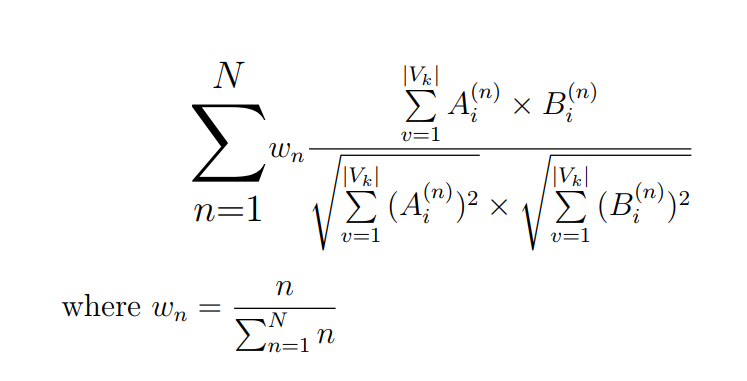

In [64]:
# weighted cosine similarity
Image("https://s3.amazonaws.com/nlp.practicum/weighted_cosine_similarity.png", width=400)

##  Similarity with gensim (generate similarity)

##### bow -> tfidf -> lsi in gensim 

In [65]:
# convert sentences into list of tokens to format data for gensim
texts = [text.split() for text in cleaned_text]
print(texts[0])

['immune_complexes', 'in', 'rheumatic', 'disease']


In [66]:
# turn our tokenized documents into a id <-> term dictionary
dictionary = corpora.Dictionary(texts)

# filter the dictionary to remove infrequent (no_below) and too frequent (no_above) terminology
dictionary.filter_extremes(no_below=.01, no_above=0.99)

print(dictionary)

Dictionary(15696 unique tokens: ['disease', 'immune_complexes', 'in', 'rheumatic', 'and']...)


In [67]:
# create bag of words (e.g. countvectorizer)
bow_corpus = [dictionary.doc2bow(sent) for sent in texts]

# create tfidf model (e.g. tfidf.fit )
tfidf = models.TfidfModel(bow_corpus)

# convert bow to tfidf (e.g. tfidf.transform)
tfidf_corpus = tfidf[bow_corpus] 

# view the first transformed sentence
print(tfidf_corpus[0])

[(0, 0.03909018618396727), (1, 0.7357717406121994), (2, 0.06241894645938989), (3, 0.6732130258569696)]


In [68]:
# create an lsi model (e.g. truncatedsvd.fit)
# corpus = data to fit model
# id2word = corpus stores words with numeric ids, this dict maps ids back to the original terms
lsi = models.LsiModel(corpus=tfidf_corpus, id2word=dictionary, num_topics=20)
print(lsi)

LsiModel(num_terms=15696, num_topics=20, decay=1.0, chunksize=20000)


In [69]:
# convert the tfidf corpus to lsi (e.g. truncatedsvd.transform)
lsi_corpus = lsi[tfidf_corpus]
print(lsi_corpus[0])

[(0, 0.022529947955653527), (1, -0.0014257055678652793), (2, -0.001426431972344654), (3, -0.008332101760692188), (4, -0.01362951290809913), (5, 0.008352936368364672), (6, 0.0016050276575971518), (7, -0.004092844674690169), (8, -0.003086545696258079), (9, -0.003424652944414306), (10, 0.0054052169791217125), (11, 0.000676162249212975), (12, 0.010800639973810646), (13, 0.002439476963905794), (14, -0.00533909869740746), (15, 0.004089545821218543), (16, -0.003876273070018574), (17, 0.0009679311967437441), (18, -0.0006025455212271179), (19, 0.0014211208769676562)]


### Index Documents for similarity recommendations (gensim)

**Compute the cosine similarity of a dynamic query against a static corpus of documents**

- gensim.similarities.**MatrixSimilarity**: for an efficient, memory-mapped index -- dense NumPy implementation


- gensim.similarities.**SparseMatrixSimilarity**: for an efficient, memory-mapped index -- sparse SciPy implementation


- gensim.similarities.**Similarity**: for an efficient out-of-core sharded index (auto-selects MatrixSimilarity or SparseMatrixSimilarity for each shard internally, based on the shard density); this is the most flexible class and should be your first choice.

In [0]:
from gensim.similarities import MatrixSimilarity, SparseMatrixSimilarity, Similarity

# transform corpus to LSI space and index it
# output_prefix - local file to write index (required to enable later additions to the index)
# corpus - data to fit model
# num_features - often the num_terms in the corpus

index = Similarity(
      output_prefix='lsi.mm'
    , corpus=lsi_corpus
    , num_features=lsi.num_terms
    , shardsize=32768
)

In [73]:
index.save(SIMILARITY_INDEX)
!ls

lsi.mm.0  pubmed.index	sample_data


In [74]:
index = Similarity.load(SIMILARITY_INDEX)
print(index)

Similarity index with 12447 documents in 1 shards (stored under lsi.mm)


### Similarity Query

In [75]:
# tokenize a query string
query = "stimulator of beta_adrenergic structure in treatment_of_ischemic heart_disease".split()
print(query, '\n')

# convert to bag of words
vec_bow = dictionary.doc2bow(query)

# convert bow to tfidf
tfidf_bow = tfidf[vec_bow] 

# convert tfidf to LSI space to prepare for similarity query
vec_lsi = lsi[tfidf_bow]

print(vec_lsi)

['stimulator', 'of', 'beta_adrenergic', 'structure', 'in', 'treatment_of_ischemic', 'heart_disease'] 

[(0, 0.024871047492174406), (1, -0.005009331511810005), (2, 0.0025634810507143943), (3, -0.005577437075573809), (4, -0.02155747505778294), (5, 0.01777189407240395), (6, -0.004589088321083583), (7, -0.009100235846255121), (8, -0.006229136821002851), (9, -0.0035165625865022565), (10, 0.006578286514835499), (11, -0.009080644145118229), (12, 0.0031951773480026514), (13, 0.005123586600719934), (14, 0.009648453298813262), (15, 0.013839457760439757), (16, -0.025878493718379348), (17, -0.00392688202893038), (18, 0.004802871025829508), (19, -0.0032975167074228316)]


In [76]:
# set the number of matches to return (sorted by most relevant)
index.num_best = 10

# perform a similarity query against the index (similarity index of training docs)
sims = index[vec_lsi]

print('num docs: {}'.format(len(sims)))
sims

num docs: 10


[(12420, 0.9471914172172546),
 (11860, 0.946020781993866),
 (2291, 0.9458433985710144),
 (7532, 0.9434422254562378),
 (2597, 0.9429491758346558),
 (1113, 0.9411954283714294),
 (6178, 0.9152464270591736),
 (8023, 0.9131218791007996),
 (6645, 0.9103840589523315),
 (11353, 0.90376216173172)]

In [77]:
# NOTE: we add the same documents to the index twice, so the returned sims number may be out of range 
# for the original texts (if so just divide the index by two before slicing texts)
print(texts[(2291)])

['insulin', 'catecholamines', 'and', 'heart_disease']


In [94]:
# add documents to a existing Similarity index (e.g. useful for big data and streaming)

print(index)  # before
index.add_documents(lsi_corpus)
print(index)  # after

Similarity index with 49788 documents in 1 shards (stored under lsi.mm)
Similarity index with 62235 documents in 1 shards (stored under lsi.mm)


##### NOTE: These queries only consider semantic similarity, and ignore important behavior driven features

### Annoy

##### Why use Annoy?

The current implementation for finding k nearest neighbors in a vector space in gensim has linear complexity via brute force in the number of indexed documents, although with extremely low constant factors. The retrieved results are exact, which is an overkill in many applications: approximate results retrieved in sub-linear time may be enough. Annoy can find approximate nearest neighbors much faster.

SOURCE: https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/annoytutorial.ipynb

### BM25 (Best Match)

- [bm25 gensim source code](https://github.com/RaRe-Technologies/gensim/blob/develop/gensim/summarization/bm25.py)

In [0]:
from gensim.summarization.bm25 import get_bm25_weights

In [80]:
%%time

scores = get_bm25_weights(bow_corpus[0:10])
print(scores[0])

[6.060835035901434, 0.0, 0.37666592049764636, 0.2804731576370509, 0.38774795150280755, 0.4394668335113332, 0.47086978310722044, 0.4394668335113332, 0.4394668335113332, 0.41199061606359444]
CPU times: user 1.04 ms, sys: 4 µs, total: 1.05 ms
Wall time: 1.06 ms


In [81]:
bm25_df = pd.DataFrame(scores).T
bm25_df['text'] = cleaned_text[0:10]
bm25_df.head()

,0,1,2,3,4,5,6,7,8,9,text
0,6.060835,0.000000,0.627909,0.627909,0.627909,0.627909,0.627909,0.627909,0.627909,0.627909,immune_complexes in rheumatic disease
1,0.000000,7.778774,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,gluten and lymphocytes in coeliac_disease
2,0.376666,0.000000,24.943328,0.376666,1.049498,1.049498,0.376666,1.457039,0.376666,0.376666,this activity correlated best with the severity and duration of the disease rather than with gamma_globulin or total protein concentrations
3,0.280473,0.000000,0.280473,33.028461,1.084941,0.280473,1.084941,1.084941,0.280473,0.280473,evidence exists that they control some of the peripheral manifestations of the disease including nervousness palpitations tachycardia increased cardiac output and tremor but they do not appear to ...
4,0.387748,0.000000,1.080376,1.499907,23.434403,1.080376,0.387748,0.387748,0.387748,1.499907,the finding of additional substitute cf antigens for the hrvl agent may have implications in the against human disease


## Similarity with SpaCy

### Similarity

spaCy is able to compare two objects, and make a prediction of how similar they are. Predicting similarity is useful for building recommendation systems or flagging duplicates. For example, you can suggest a user content that's similar to what they're currently looking at, or label a support ticket as a duplicate if it's very similar to an already existing one.

In [84]:
!python -m spacy download en_core_web_lg

     |████████████████████████████████| 826.9MB 1.1MB/s 
  Stored in directory: /tmp/pip-ephem-wheel-cache-o1g8s1pp/wheels/b4/d7/70/426d313a459f82ed5e06cc36a50e2bb2f0ec5cb31d8e0bdf09
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [0]:
import en_core_web_lg
nlp = en_core_web_lg.load()

##### Document Similarity

In [97]:
from itertools import combinations

doc1 = nlp(u"Paris is the largest city in France.")
doc2 = nlp(u"Vilnius is the capital of Lithuania.")
doc3 = nlp(u"An emu is a large bird.")
doc4 = nlp(u"seagulls flying by the beach")

doc_combos = list(combinations([doc1, doc2, doc3, doc4], r=2))
doc_combos

[(Paris is the largest city in France., Vilnius is the capital of Lithuania.),
 (Paris is the largest city in France., An emu is a large bird.),
 (Paris is the largest city in France., seagulls flying by the beach),
 (Vilnius is the capital of Lithuania., An emu is a large bird.),
 (Vilnius is the capital of Lithuania., seagulls flying by the beach),
 (An emu is a large bird., seagulls flying by the beach)]

In [98]:
for doc, other_doc in doc_combos:
    print(doc)
    print(other_doc)
    print(doc.similarity(other_doc), '\n')

Paris is the largest city in France.
Vilnius is the capital of Lithuania.
0.7554965262954281 

Paris is the largest city in France.
An emu is a large bird.
0.6921461821156969 

Paris is the largest city in France.
seagulls flying by the beach
0.5691887753380548 

Vilnius is the capital of Lithuania.
An emu is a large bird.
0.5668025741640493 

Vilnius is the capital of Lithuania.
seagulls flying by the beach
0.4577827526596423 

An emu is a large bird.
seagulls flying by the beach
0.5974336979105327 



### Word2Vec Similarity Examples:

SOURCE: https://quomodocumque.wordpress.com/2016/01/15/messing-around-with-word2vec/

### Similarities in context

Aside from spaCy's built-in word vectors, which were trained on a lot of text with a wide vocabulary, the parsing, tagging and NER models also rely on vector representations of the meanings of words in context. As the processing pipeline is applied spaCy encodes a document's internal meaning representations as an array of floats, also called a tensor. This allows spaCy to make a reasonable guess at a word's meaning, based on its surrounding words. Even if a word hasn't been seen before, spaCy will know something about it. Because spaCy uses a 4-layer convolutional network, the tensors are sensitive to up to four words on either side of a word.

In [0]:
# Cartesian product of input iterables.  Equivalent to nested for-loops.
from itertools import product

In [100]:
list(product([['sentence1'],['sentence2'],['sentence3']], repeat=2))

[(['sentence1'], ['sentence1']),
 (['sentence1'], ['sentence2']),
 (['sentence1'], ['sentence3']),
 (['sentence2'], ['sentence1']),
 (['sentence2'], ['sentence2']),
 (['sentence2'], ['sentence3']),
 (['sentence3'], ['sentence1']),
 (['sentence3'], ['sentence2']),
 (['sentence3'], ['sentence3'])]

In [0]:
def create_similarity_matrix(texts, size, labels=None, viz=True):
    """ build a heatmap of similarity scores """

    # create a heatmap of similarities by iterating through each term 
    # and calculating its similarity to every other term
    # similarity is determined by comparing word vectors or "word embeddings"
    matrix = [t1.similarity(t2) for t1, t2 in product(texts, repeat=2)]
    
    # remove bottom half of matrix (i.e. duplicate data)
    matrix = np.array(matrix).reshape(size,size)    
    matrix = np.triu(matrix)
    
    # transform similarity scores into a dataframe
    if labels is None:
        labels = [term for term in texts]
    df = pd.DataFrame(matrix, columns=labels, index=labels)
    
    # create a heat map of the similarity scores
    if viz:
        sns.set(rc={'figure.figsize':(10,8)})
        sns.heatmap(df.values)
    
    return df

,immune_complexes,in,rheumatic,disease
immune_complexes,1.0,0.0,0.000000,0.000000
in,0.0,1.0,0.010146,0.295201
rheumatic,0.0,0.0,1.000000,0.550529
disease,0.0,0.0,0.000000,1.000000


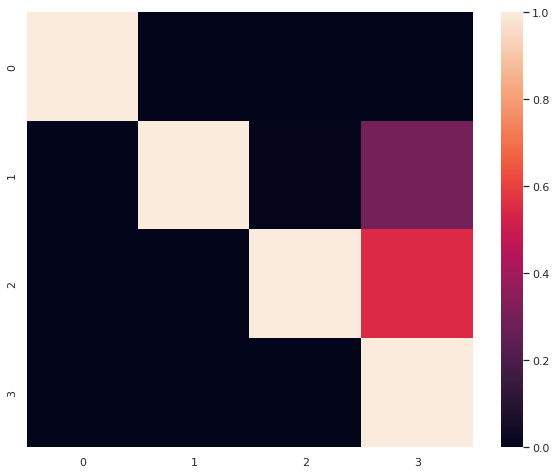

In [120]:
#sns.set(rc={'figure.figsize':(12,10)})
create_similarity_matrix(
      nlp(cleaned_text[0])
    , size=len(cleaned_text[0].split())
)

##### Sentence Similarity using the full dataset

In [0]:
from itertools import combinations

In [122]:
list(combinations([['sentence1'],['sentence2'],['sentence3']], r=2))

[(['sentence1'], ['sentence2']),
 (['sentence1'], ['sentence3']),
 (['sentence2'], ['sentence3'])]

In [123]:
%%time

# use set to avoid looking at the similarity of dupliate sentences
docs = [nlp(sentence) for sentence in set(cleaned_text[0:1000])]

CPU times: user 10.9 s, sys: 26.8 ms, total: 10.9 s
Wall time: 11 s


In [124]:
%%time

# compare the similarity of all sentences against each other
similarity_scores = []
for doc1, doc2 in combinations(docs, r=2):
    sentences_are_different = doc1.text != doc2.text
    if sentences_are_different:
        similarity_scores.append([doc1.text, doc2.text, doc1.similarity(doc2)])

# view the top most similar sentences
# drop sentences with greater than .99 similarity as these are often duplicates
df = pd.DataFrame(similarity_scores, columns=['doc1','doc2','similarity'])
df[df.similarity < .97].sort_values('similarity', ascending=False).head(10)

CPU times: user 2min 35s, sys: 1.3 s, total: 2min 37s
Wall time: 2min 37s


### Word Movers Distance

INSTALLATION: conda install -c conda-forge pyemd 

From Word Embeddings To Document Distances Abstract: http://proceedings.mlr.press/v37/kusnerb15.pdf

In [127]:
import gensim.downloader as api
word_vectors = api.load("glove-wiki-gigaword-100")  # load pre-trained word-vectors from gensim-data

[==================================================] 100.0% 128.1/128.1MB downloaded


In [128]:
# Word Mover's Distance

# example sentences
sentence_obama = 'Obama speaks to the media in Illinois'.lower().split()
sentence_president = 'The president greets the press in Chicago'.lower().split()

# Compute WMD.
distance = word_vectors.wv.wmdistance(document1=sentence_obama, document2=sentence_president)
distance

3.4892687395218687

In [129]:
doc1.text

'twenty one patients with beh_et disease were typed for hla_antigens'

In [131]:
%%time

# compare the similarity of all sentences against each other
similarity_scores = []
for doc1, doc2 in combinations(docs, r=2):
    sentences_are_different = doc1.text != doc2.text
    if sentences_are_different:
        wmd = word_vectors.wv.wmdistance(
            document1=simple_preprocess(doc1.text)
          , document2=simple_preprocess(doc2.text)
        )
        similarity_scores.append([doc1.text, doc2.text, wmd])

CPU times: user 39min 19s, sys: 7.4 s, total: 39min 26s
Wall time: 39min 26s


In [132]:
df = pd.DataFrame(similarity_scores, columns=['doc1','doc2','word_movers_distance'])
df = df[df.word_movers_distance != np.inf]
df.sort_values('word_movers_distance', ascending=True).head(10)

,doc1,doc2,word_movers_distance
63190,autoxidation in peripheral_vascular disease,risk_factors in coronary_heart disease,0.000000
63776,autoxidation in peripheral_vascular disease,oestrogens in ischaemic_heart disease,0.000000
283875,risk_factors in hodgkin_disease,deprenyl in parkinson_disease,0.000000
320984,risk_factors in coronary_heart disease,oestrogens in ischaemic_heart disease,0.000000
390146,incidence of hereditary disease in man,the incidence of hereditary disease in man,0.801347
258746,twenty six of these patients had connective_tissue disease,thirteen of these patients had connective_tissue disease,1.083271
292535,propranolol and peyronie disease,glycosylated haemoglobins and disease,1.510279
316458,stereology new morphological method of study prostatic function and disease,stereology new quantitative morphological approach to study prostatic function and disease,1.663347
123572,prenatal_diagnosis of genetic disease,non_invasive diagnosis of congenital_heart disease,1.760639
499429,oestrogens in ischaemic_heart disease,lymphocytotoxic_antibodies in still disease,1.872749


# Similarity of Probability Distributions

In [0]:
from gensim.utils import simple_preprocess
from gensim.matutils import kullback_leibler, hellinger

In [134]:
# view the first document
cleaned_text_df['text'][1]

'gluten and lymphocytes in coeliac_disease'

In [135]:
# use gensim to preprocess the document
print(simple_preprocess(cleaned_text_df['text'][1]))

['gluten', 'and', 'lymphocytes', 'in', 'coeliac_disease']


In [0]:
# preprocess all documents
clean_text = [simple_preprocess(text) for text in cleaned_text_df['text']]

# build bag of words
dictionary = Dictionary(clean_text)
corpus = [dictionary.doc2bow(text) for text in clean_text]

# create LDA model
model = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=3)

In [137]:
# create a bag of words for select documents
doc1 = model.id2word.doc2bow(simple_preprocess('abdominal pain persisted throughout treatment'))
doc2 = model.id2word.doc2bow(simple_preprocess('the patient had stomach discomfort'))
doc3 = model.id2word.doc2bow(simple_preprocess('the president greets the press in chicago'))

# we can now get the LDA topic distributions for these documents
doc1_dist = model[doc1] 
doc2_dist = model[doc2] 
doc3_dist = model[doc3] 

# view results
print('doc1_dist: {}'.format(doc1_dist))
print('doc2_dist: {}'.format(doc2_dist))
print('doc3_dist: {}'.format(doc3_dist))

doc1_dist: [(0, 0.057836745), (1, 0.05658176), (2, 0.8855815)]
doc2_dist: [(0, 0.071443155), (1, 0.063924514), (2, 0.8646323)]
doc3_dist: [(0, 0.07109952), (1, 0.28426147), (2, 0.6446391)]


##### Kullback Leibler Divergence

Kullback-Leibler returns a value in range [0, +∞) where values closer to 0 mean less distance (higher similarity).

The KL divergence is a measure of how much “predictive power” or “evidence” each sample will on average bring when you’re trying to distinguish p(x) from q(x), if you’re sampling from p(x). If p(x) and q(x) are very similar then each individual sample will bring little “evidence” to the table. On the other hand, if p(x) and q(x) are very different then each sample will bring a lot of evidence showcasing that q(x) is not a good representation of p(x).

In practice you’re often in situations where you want to build a model that’s as close as possible to the “true” model. In that case, you would like it to be as difficult as possible to distinguish the model you built from the real one, especially for samples that have been sampled from the real model.

SOURCE: https://medium.com/@cotra.marko/making-sense-of-the-kullback-leibler-kl-divergence-b0d57ee10e0a

##### Great Explanation of Entropy, Cross-Entropy, and KL-Divergence

[A Short Introduction to Entropy, Cross-Entropy and KL-Divergence](https://www.youtube.com/watch?v=ErfnhcEV1O8)

In [138]:
kullback_leibler(doc1_dist, doc2_dist)

0.002077436

In [139]:
kullback_leibler(doc1_dist, doc3_dist)

0.17794436

##### Hellinger distance

The Hellinger distance metric gives an output in the range [0,1] for two probability distributions, with values closer to 0 meaning they are more similar.

SOURCE: https://en.wikipedia.org/wiki/Hellinger_distance

In [140]:
hellinger(doc1_dist, doc2_dist)

0.02310097667726649

In [141]:
hellinger(doc1_dist, doc3_dist)

0.23126781079341185

# Sentence Clustering

In [36]:
# file names for lesson
NIH_EXPORTER_CSV = r'https://exporter.nih.gov/CSVs/final/RePORTER_PRJ_C_FY2019_042.zip'
cols = ['PROJECT_TITLE']
reporter = pd.read_csv(NIH_EXPORTER_CSV, encoding='latin-1', usecols=cols)

# remove duplicates
reporter = reporter[~reporter.PROJECT_TITLE.duplicated()]

reporter.shape

(1005, 1)

In [0]:
# vectorize the text
vect = TfidfVectorizer(min_df=.01, max_df=.95, norm='l2', stop_words='english', max_features=1000, ngram_range=(1,2))
titles_vect = vect.fit_transform(reporter['PROJECT_TITLE'])

In [42]:
%%time

# cluster the document using KMeans

# step 1 - import the model
from sklearn.cluster import KMeans

# step 2 - instantiate the model
km = KMeans(n_clusters=100, random_state=42)

# step 3 - fit the model with data
# clustering is unsupervised so we do not have labels to add during .fit()
km.fit(titles_vect)

# step 4 - predict the cluster of each section_title
reporter['clusters'] = km.predict(titles_vect)

CPU times: user 1.09 s, sys: 0 ns, total: 1.09 s
Wall time: 1.1 s


In [43]:
def review_clusters(df, n_clusters):
    for cl_num in range(n_clusters):
        print(cl_num)
        print(reporter[df.clusters == cl_num]['PROJECT_TITLE'].values[0:10])
        print()

review_clusters(reporter, n_clusters=100)

0
['Flow Cytometry Shared Resources' 'Epigenetics of Regeneration'
 'Mismatch Repair Proteins as Drivers of Temozolomide Resistance in Glioblastoma'
 'APOBEC PROTEINS AND RIBOVIRAL RESTRICTION'
 'Cognitive Genomics as a Window on Neurodevelopment and Psychopathology'
 'Studying Inclusive Mentor Networks to Diversify the Biomedical Workforce'
 'KLF9-TXNRD2 axis in melanoma progression and metastasis'
 'Dopaminergic modulation of spinal locomotor circuits'
 'Identification of essential kinases in Leishmania'
 'Bioengineered Composite Alveolar Bone-Tooth Constructs for Tooth Regeneration']

1
['Administrative Core' 'BGSU Administrative Core' 'Genomics Core'
 'CUPC Sci-Tech Core' 'Core - Satellite' 'Admin Core' 'Mouse Core'
 'Core B: Clinical Core'
 'Understanding the Functions of a key RNA Base Pair in the Catalytic Core of the Spliceosome'
 'MCUAAAR Admin-Core']

2
['Institutional Career Development Core' 'Development Core'
 'The Behavioral Assessment Screening Tool (BAST): Psychometric 